# LSTM et GRU sur stock price de alpha_vantage
- intègre les splits pour lisser les données de marchés
- compare deux LSTM et un GRU, avec une approche train,val,test

Auteur : Y. Lacroix

### Importation des librairies

In [1]:
import os
import yfinance as yf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import json, time, pickle
from PIL import Image as PILImage
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
from alpha_vantage.timeseries import TimeSeries 
from IPython.display import Image, display, clear_output
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import Callback

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Dropout , GRU,Input,Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

### Constantes, loads, helpers élémentaires

In [2]:
dailies='1min, 5min, 15min, 30min, 60min'.split(', ')
columns=["open","high","low","close","volume"]
models=dict()
histories=dict()
API_KEY=open("alpha_api_key.txt","r").read()
companies_data = json.load(open('companies_list.txt'))
companies_dict = {data["ticker"]: (data["name"], data["sector"], data["industry"]) for data in companies_data}
def plot_col(df,col):
    plt.figure(figsize=(16,3))
    plt.plot(df.index,df[col])
    plt.xlabel('Date')
    xticks,labels=range(0,len(df),312),list(df.index)[::312]
    plt.xticks(xticks,labels,rotation=30,fontsize=6)
    plt.ylabel(col)
    plt.title(f"Plot of {col}")
    plt.show()

def apply_split(df,date,value):
    for col in ['open','high','low','close']:
        df.loc[df.index < date, col] = df.loc[df.index < date, col] / value
    df.loc[df.index < date, 'volume'] = df.loc[df.index < date, 'volume'] * value
    return df

### Un callback pour l'arrêt des entrainements

In [3]:
class Patience(Callback):
    def __init__(self, name,patience):
        super().__init__()
        self.name=name
        self.patience=patience
        self.min_val=float('inf')
        self.turns_without_improvement=0

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get(self.name)
        if current_loss is not None and current_loss < self.min_val:
            self.min_val=current_loss
            self.turns_without_improvement=0
        else:
            self.turns_without_improvement+=1
        if self.turns_without_improvement>self.patience:
            print(f"\nStopping training: loss did not decrease for {self.patience} epochs. Current {self.name}: {current_loss:.4f}")
            self.model.stop_training = True

### Une classe "Compagny" : 
- ticker, interval (par défaut daily), name, sector, industry et dates
- méthodes __repr__, __set_data__, __get_data__

In [4]:
class Company:
    def __init__(self, ticker,interval='1D'):
        self.ticker=ticker
        self.interval=interval
        self.name,self.sector,self.industry = companies_dict[ticker]
        self.splits=yf.Ticker(self.ticker).splits
        self.splits={k.strftime("%Y-%m-%d"):v for k,v in self.splits.items()}
        self.dates=None
    def __repr__(self):
        return f"Company :{self.ticker} --> {self.name} ({self.sector}, {self.industry}, interval={self.interval})"
    def set_data(self):
        """period in '1d','w','1m', attention yfinance accès limité hors premium"""
        if self.interval not in dailies+['1D','1M']:
            print(f"interval not correct, select one in {dailies+['1D','1M']}")
            return
        file_name=f"{self.ticker}_{self.interval}.csv"
        ts = TimeSeries(key=API_KEY, output_format='pandas')
        if self.interval in dailies:
            data,metadata=ts.get_intraday(symbol=self.ticker, interval=self.interval,outputsize='full')
        elif self.interval=='1D':
            data,metadata=ts.get_daily(symbol=self.ticker, outputsize='full')
        elif self.interval=='1M':
            data,metadata=ts.get_monthly(symbol=self.ticker,outputsize='full')
        data.columns=columns
        data.index=data.index.strftime('%Y-%m-%d')
        data=data.iloc[::-1]
        for date in sorted(self.splits,reverse=True):
            if data.index[0]<date and date<=data.index[-1]:
                print(f"Applying unsplit at date {date} with value {self.splits[date]}")
                data=apply_split(data,date,self.splits[date])
        data.to_csv(file_name,index=True)
        self.dates=list(data.index)
        with open(f"{self.ticker}_{self.interval}_metadata.json", 'w') as f:
            json.dump(metadata, f, indent=4)
    def get_data(self):
        if self.interval not in dailies+['1D','1M']:
            print(f"interval not correct, select one in {dailies+['1D','1M']}")
            return None
        file_name=f"{self.ticker+'_'+self.interval}.csv"
        if file_name not in os.listdir():
            self.set_data()
        return pd.read_csv(file_name,index_col=0),json.load(open(f"{self.ticker+'_'+self.interval}_metadata.json"))
        

In [5]:
goog=Company('GOOG')
print(goog)
goog.set_data()
df,metadata=goog.get_data()
print(f"metadata={metadata}")
df.head()

Company :GOOG --> Alphabet Inc. (Class C) (Communication Services, Interactive Media, interval=1D)
Applying unsplit at date 2022-07-18 with value 20.0
Applying unsplit at date 2015-04-27 with value 1.0027455
metadata={'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'GOOG', '3. Last Refreshed': '2024-11-29', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}


,open,high,low,close,volume
date,,,,,
2014-03-27,28.322241,28.322241,27.570306,27.846547,262719.321
2014-03-28,27.983172,28.243956,27.857019,27.922838,824256.801
2014-03-31,28.266893,28.272378,27.770257,27.772251,216593.028
2014-04-01,27.859013,28.344680,27.859013,28.280356,158433.789
2014-04-02,28.177937,30.158699,28.032537,28.272378,2942055.297


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
open,2689.0,7.794826e+01,4.432716e+01,24.664783,3.922500e+01,6.017050e+01,1.156480e+02,1.917500e+02
high,2689.0,7.877317e+01,4.481805e+01,24.730901,3.949350e+01,6.060075e+01,1.173395e+02,1.933100e+02
low,2689.0,7.717899e+01,4.387779e+01,24.311253,3.902900e+01,5.972900e+01,1.143923e+02,1.906200e+02
close,2689.0,7.798905e+01,4.434143e+01,24.560070,3.929700e+01,6.025500e+01,1.157650e+02,1.926600e+02
volume,2689.0,3.124422e+07,1.582462e+07,158433.789000,2.145916e+07,2.738095e+07,3.614654e+07,2.232989e+08


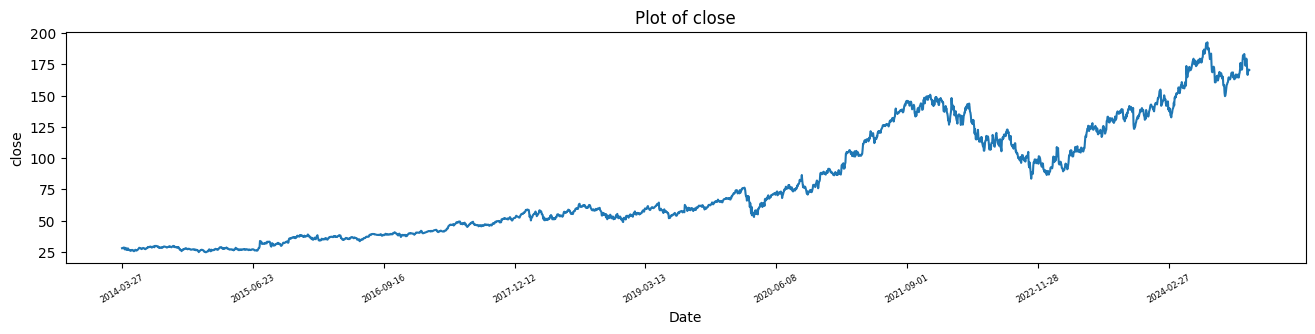

In [7]:
plot_col(df,'close')

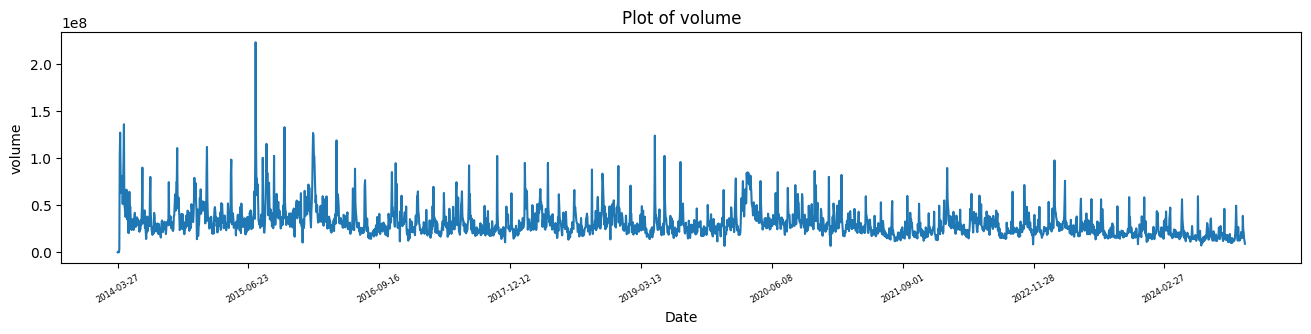

In [8]:
plot_col(df,'volume')

### Affichage des moyennes mobiles : 6,30,60,90 jours

In [9]:
W6 = df.rolling(window=6).mean()
W30 = df.rolling(window=30).mean()
W60 = df.rolling(window=60).mean()
W90 = df.rolling(window=90).mean()

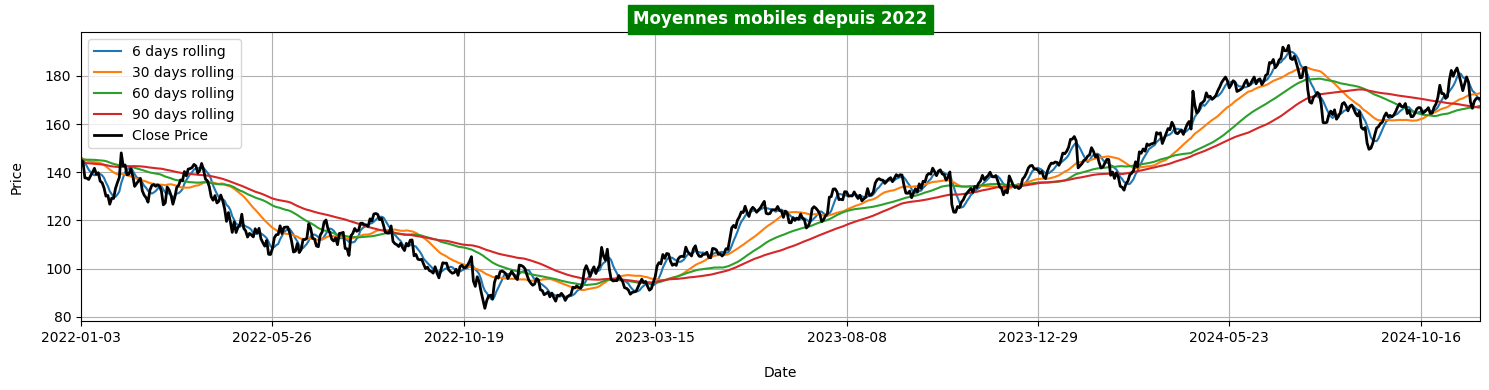

In [10]:
plt.figure(figsize=(15,4))
W6['close'][df.index>"2022"].plot(label='6 days rolling').autoscale(axis='x',tight=True)
W30['close'][df.index>"2022"].plot(label='30 days rolling').autoscale(axis='x',tight=True)
W60['close'][df.index>"2022"].plot(label='60 days rolling').autoscale(axis='x',tight=True)
W90['close'][df.index>"2022"].plot(label='90 days rolling').autoscale(axis='x',tight=True)
df['close'][df.index>"2022"].plot(label='Close Price',color='k',linestyle='-',linewidth=2).autoscale(axis='x',tight=True)
plt.legend()
plt.title('Moyennes mobiles depuis 2022',backgroundcolor='g',color='white',fontweight='bold')  
plt.xlabel('Date',labelpad=15)
plt.ylabel('Price',labelpad=15)
plt.grid(True)
plt.tight_layout()
plt.show()

### Standard scaling des données :
!['Les scalers'](scalers.png )


In [11]:
scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(df)
scaled=pd.DataFrame(scaled_data,columns=df.columns,index=df.index)
scaled.head()

,open,high,low,close,volume
date,,,,,
2014-03-27,0.021890,0.021304,0.019596,0.019551,0.000467
2014-03-28,0.019860,0.020839,0.021320,0.020005,0.002984
2014-03-31,0.021559,0.021008,0.020799,0.019109,0.000261
2014-04-01,0.019117,0.021437,0.021332,0.022131,0.000000
2014-04-02,0.021026,0.032197,0.022376,0.022084,0.012475


### Train/Test split et préparation des données:
On prépare les données en spécifiant la taille de fenêtre servant la mémoire du modèle (window_size)

In [12]:
train_size=round(len(scaled)*0.8)
val_size=round(train_size*0.75)
train,val,test_set=scaled[:val_size],scaled[val_size:train_size],scaled[train_size:]
print(f"train_size={val_size}, val_size={train_size-val_size}, test_size={len(scaled)-train_size}")

train_size=1613, val_size=538, test_size=538


In [13]:
def prepare_time_series_data(Data, window_size):
    data_array = Data.values
    sequences = np.array([data_array[i:i+window_size] for i in range(len(data_array) - window_size)])
    labels = data_array[window_size:]
    return sequences, labels

In [14]:
window_size=60
X_all, y_all=prepare_time_series_data(scaled, window_size)
X_train, y_train = prepare_time_series_data(train, window_size)
X_val,y_val=prepare_time_series_data(val, window_size)
X_test, y_test = prepare_time_series_data(test_set, window_size)
print(f"shapes : X_train: {X_train.shape}, y_train: {y_train.shape}, X_val: {X_val.shape}, y_val: {y_val.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"X_all: {X_all.shape}, y_all: {y_all.shape}")

shapes : X_train: (1553, 60, 5), y_train: (1553, 5), X_val: (478, 60, 5), y_val: (478, 5), X_test: (478, 60, 5), y_test: (478, 5)
X_all: (2629, 60, 5), y_all: (2629, 5)


### Premier modèle LSTM simple:
- RNN + Dropout
- deux couches

In [15]:
LSTM1 = Sequential()
LSTM1.add(Input(shape=(window_size,X_train.shape[2])))
LSTM1.add(LSTM(100,return_sequences=True))
LSTM1.add(Dropout(0.2))
LSTM1.add(LSTM(100,return_sequences=False))
LSTM1.add(Dropout(0.2))
LSTM1.add(Dense(X_train.shape[2]))
LSTM1.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'])

LSTM1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,305 (481.66 KB)

 Trainable params: 123,305 (481.66 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
%%time
early_stop=Patience('loss',3)
histories['LSTM1'] = LSTM1.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop],verbose=1)
models['LSTM1'] = LSTM1
clear_output()
print()


CPU times: user 11min 8s, sys: 1min 13s, total: 12min 21s
Wall time: 3min 10s


In [17]:
for key in histories['LSTM1'].history.keys():
    print(key," : ",histories["LSTM1"].history[key][-1])

loss  :  0.0008423051331192255
mean_absolute_error  :  0.014433824457228184
val_loss  :  0.0012787084560841322
val_mean_absolute_error  :  0.02964378334581852


[Text(0.5, 0, ' Epochs ')]

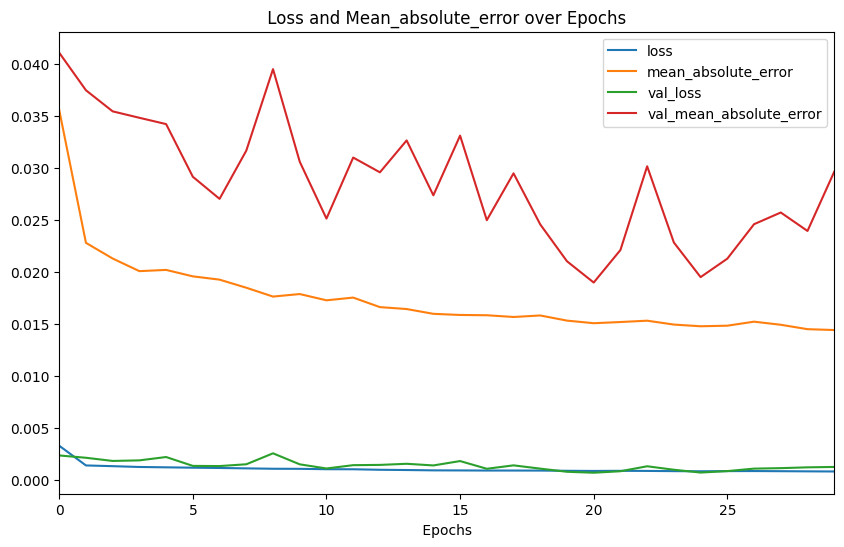

In [18]:
title=' Loss and Mean_absolute_error over Epochs '
xlabel=' Epochs '
LSTM1_losses = pd.DataFrame(LSTM1.history.history)
ax = LSTM1_losses.plot(figsize=(10,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel)

In [19]:
LSTM1_losses.tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
25,0.000878,0.014851,0.000880,0.021293
26,0.000884,0.015237,0.001117,0.024603
27,0.000870,0.014940,0.001164,0.025727
28,0.000856,0.014516,0.001241,0.023954
29,0.000842,0.014434,0.001279,0.029644


In [20]:
def predict_and_inverse_transform(DF,model,scaler,start=None, stop=None):
    if start is None:start=0
    if stop is None:stop=len(DF)
    tranche=slice(start,stop,None)
    test_set=X_all[tranche]
    predictions = model.predict(test_set)
    inverse_predictions = scaler.inverse_transform(predictions)
    test_df = pd.DataFrame(inverse_predictions,columns=[col+'_pred' for col in DF.columns],index=DF.iloc[start+window_size:min(stop+window_size,len(df))].index)
    return test_df

In [21]:
test_df_1_val = predict_and_inverse_transform(df, LSTM1, scaler,val_size,train_size)
test_df_1_test = predict_and_inverse_transform(df, LSTM1, scaler,train_size,len(df))
print(f"len(test_df_1_val)={len(test_df_1_val)}, len(test_df_1_test)={len(test_df_1_test)}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
len(test_df_1_val)=538, len(test_df_1_test)=478


start_index=1344


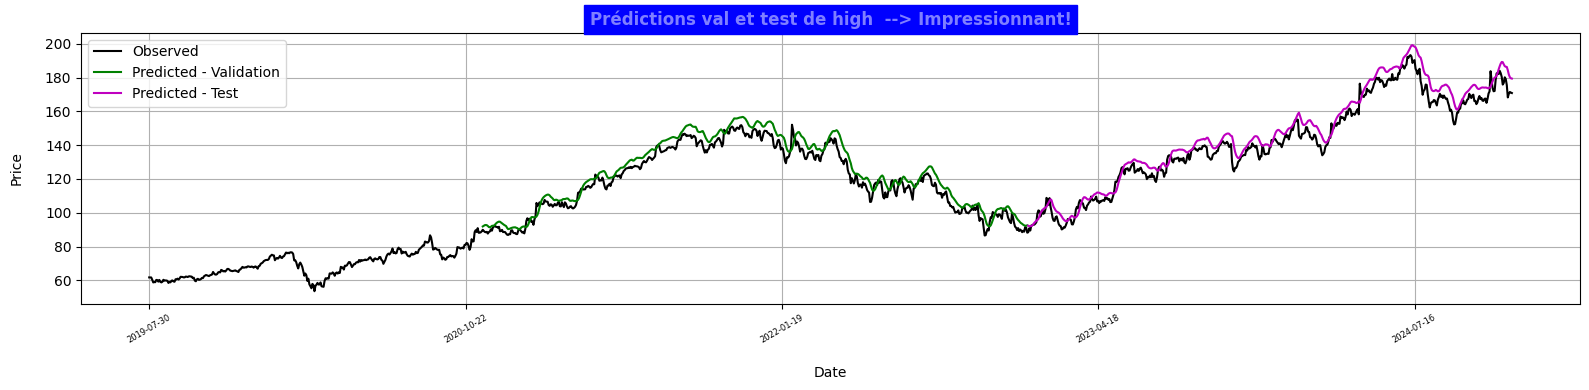

In [22]:
col='high'
col_index=df.columns.get_loc(col)
indexes=df.index.to_list()
start_plot_date=indexes[len(indexes)//2]
start_index=indexes.index(start_plot_date)
print(f"start_index={start_index}")
plt.figure(figsize=(16,4))
plt.plot(df.index[start_index:], df[col][start_index:], label='Observed', color='k')
plt.plot(test_df_1_val.index, test_df_1_val[col+'_pred'], label='Predicted - Validation',color='g')
plt.plot(test_df_1_test.index, test_df_1_test[col+'_pred'], label='Predicted - Test',color='m')
plt.legend()
plt.title(f"Prédictions val et test de {col}  --> Impressionnant!",backgroundcolor='b',alpha=0.5,color='white',fontweight='bold')  
plt.xlabel('Date',labelpad=15)
plt.ylabel('Price',labelpad=15)
plt.xticks(df.index[start_index::312],rotation=30,fontsize=6)
plt.grid(True)
plt.tight_layout()


### Deuxième LSTM :
- trois couches LSTM avec Dropout
- une couche dense

In [23]:
LSTM2 = Sequential()

# First LSTM layer
LSTM2.add(Input(shape=(window_size,X_train.shape[2])))
LSTM2.add(LSTM(150, return_sequences=True))
LSTM2.add(Dropout(0.2))
# Second LSTM layer
LSTM2.add(LSTM(100, return_sequences=True))
LSTM2.add(Dropout(0.2))
# Third LSTM layer 
LSTM2.add(LSTM(100, return_sequences=False)) 
LSTM2.add(Dropout(0.2))
# Final Prediction (one neuron per feature)
LSTM2.add(Dense(units=50))
LSTM2.add(Dense(units=5))
LSTM2.add(Dense(X_train.shape[2]))

LSTM2.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'])
LSTM2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 150)        │        93,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 100)        │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           255 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,735 (1.07 MB)

 Trainable params: 279,735 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
%%time
early_stop = early_stop=Patience('loss',3)
histories['LSTM2'] = LSTM2.fit(X_train, y_train,epochs=30,validation_data=(X_val, y_val),batch_size = 32,callbacks=[early_stop],verbose=1)
models['LSTM2'] = LSTM2
clear_output()
print()


CPU times: user 21min 56s, sys: 2min 31s, total: 24min 28s
Wall time: 5min 20s


In [25]:
test_df_2_test = predict_and_inverse_transform(df, LSTM2, scaler,train_size,len(df))
test_df_2_val = predict_and_inverse_transform(df, LSTM2, scaler,val_size,train_size)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


### Modèle GRU : 
- une couche GRU
- une couche Dense

In [26]:
GRU_Model = Sequential()
GRU_Model.add(Input(shape=(window_size, X_train.shape[2])))
GRU_Model.add(GRU(128, activation='tanh'))
GRU_Model.add(Dense(X_train.shape[2]))
GRU_Model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
GRU_Model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,485 (205.02 KB)

 Trainable params: 52,485 (205.02 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
%%time
early_stop = early_stop=Patience('loss',3)
histories['GRU'] = GRU_Model.fit(X_train, y_train, epochs=30,validation_data=(X_val, y_val),batch_size = 32,callbacks=[early_stop],verbose=1)
models['GRU'] = GRU_Model
clear_output()
print()


CPU times: user 2min 27s, sys: 15 s, total: 2min 42s
Wall time: 42.8 s


In [28]:
test_df_3_test = predict_and_inverse_transform(df, GRU_Model, scaler,train_size,len(df))
test_df_3_val = predict_and_inverse_transform(df, GRU_Model, scaler,val_size,train_size)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


### Bidirectionnal GRU:
- une couche Bidirectionnal sur GRU suivie de dropout

In [29]:
GRU_bidirectional = Sequential()
GRU_bidirectional.add(Input(shape=(window_size, X_train.shape[2])))
GRU_bidirectional.add(Bidirectional(GRU(128, activation='tanh')))
GRU_bidirectional.add(Dropout(0.2))
GRU_bidirectional.add(Dense(X_train.shape[2]))

GRU_bidirectional.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'])
GRU_bidirectional.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 256)            │       103,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,965 (410.02 KB)

 Trainable params: 104,965 (410.02 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
%%time
early_stop =Patience('loss',3)
histories['GRU_bidirectional'] = GRU_bidirectional.fit(X_train, y_train, epochs=30,validation_data=(X_val, y_val),batch_size = 32,callbacks=[early_stop],verbose=1)
models['GRU_bidirectional'] = GRU_bidirectional
clear_output()
print()


CPU times: user 7min 16s, sys: 45.5 s, total: 8min 2s
Wall time: 1min 7s


In [31]:
test_df_4_test = predict_and_inverse_transform(df, GRU_bidirectional, scaler,train_size,len(df))
test_df_4_val = predict_and_inverse_transform(df, GRU_bidirectional, scaler,val_size,train_size)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


start_index=2019-07-30


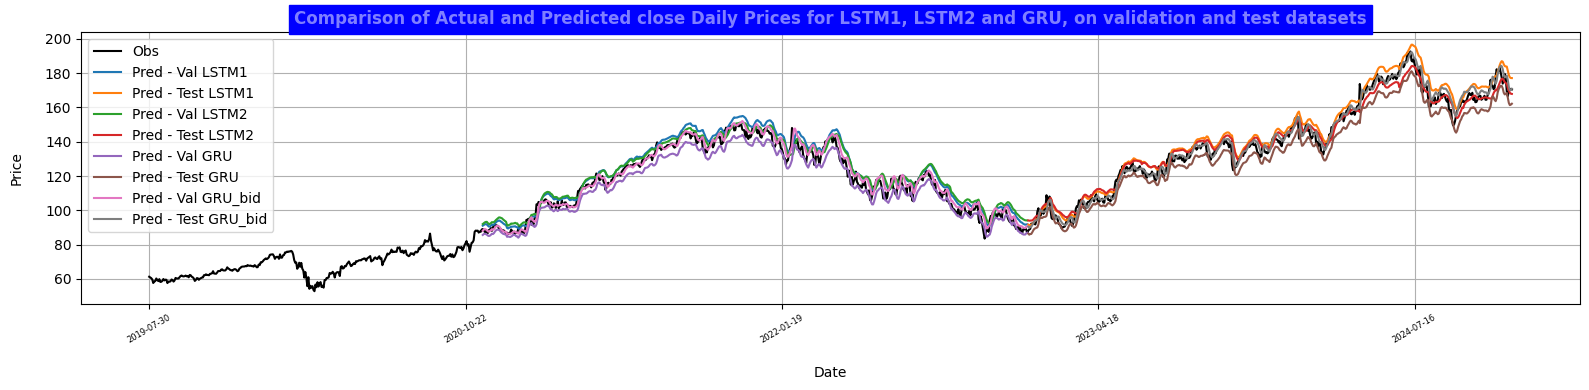

In [32]:
col='close'
col_index=df.columns.get_loc(col)
indexes=df.index.to_list()
start_plot_date="2013-06-25"
start_index=indexes[len(indexes)//2]
print(f"start_index={start_index}")
plt.figure(figsize=(16,4))
plt.plot(df.index[len(indexes)//2:], df[col][start_index:], label='Obs', color='k')
plt.plot(test_df_1_val.index, test_df_1_val[col+'_pred'], label='Pred - Val LSTM1',)
plt.plot(test_df_1_test.index, test_df_1_test[col+'_pred'], label='Pred - Test LSTM1')
plt.plot(test_df_2_val.index, test_df_2_val[col+'_pred'], label='Pred - Val LSTM2',)
plt.plot(test_df_2_test.index, test_df_2_test[col+'_pred'], label='Pred - Test LSTM2')
plt.plot(test_df_3_val.index, test_df_3_val[col+'_pred'], label='Pred - Val GRU',)
plt.plot(test_df_3_test.index, test_df_3_test[col+'_pred'], label='Pred - Test GRU')
plt.plot(test_df_4_val.index, test_df_4_val[col+'_pred'], label='Pred - Val GRU_bid')
plt.plot(test_df_4_test.index, test_df_4_test[col+'_pred'], label='Pred - Test GRU_bid')

plt.legend()
plt.title(f"Comparison of Actual and Predicted {col} Daily Prices for LSTM1, LSTM2 and GRU, on validation and test datasets",
          backgroundcolor='b',alpha=0.5,color='white',fontweight='bold')  
plt.xlabel('Date',labelpad=15)
plt.ylabel('Price',labelpad=15)
plt.xticks(df.index[len(indexes)//2::312],rotation=30,fontsize=6)
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
for name in histories:
    print(name)
    for k,v in histories[name].history.items():
        print(f"k={k}, v={v[-1]}")  

LSTM1
k=loss, v=0.0008423051331192255
k=mean_absolute_error, v=0.014433824457228184
k=val_loss, v=0.0012787084560841322
k=val_mean_absolute_error, v=0.02964378334581852
LSTM2
k=loss, v=0.0008680035825818777
k=mean_absolute_error, v=0.01508550625294447
k=val_loss, v=0.0011183589231222868
k=val_mean_absolute_error, v=0.025880945846438408
GRU
k=loss, v=0.000781766080763191
k=mean_absolute_error, v=0.01168795581907034
k=val_loss, v=0.0007250624476000667
k=val_mean_absolute_error, v=0.01979401521384716
GRU_bidirectional
k=loss, v=0.0008455901988781989
k=mean_absolute_error, v=0.014464707113802433
k=val_loss, v=0.0007468434050679207
k=val_mean_absolute_error, v=0.019594643265008926


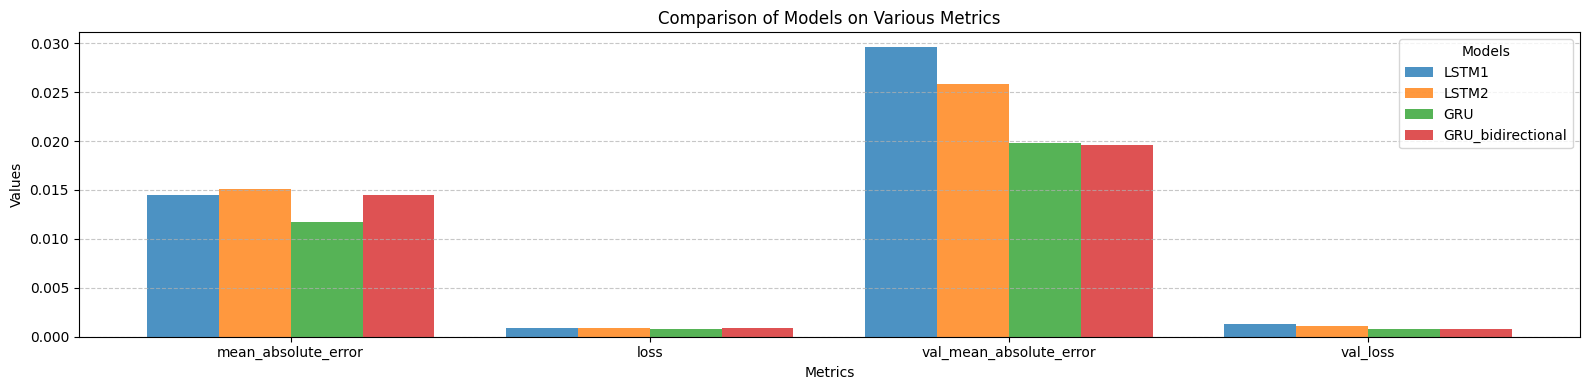

In [36]:
metrics = ['mean_absolute_error', 'loss', 'val_mean_absolute_error', 'val_loss']
results={name:[histories[name].history[k][-1] for k in metrics] for name in histories}
x = np.arange(len(metrics))  
bar_width = 0.2
plt.figure(figsize=(16,4))
for i,(name,values) in enumerate(results.items()):
    plt.bar(x+i*bar_width, values, bar_width, label=name,alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Models on Various Metrics')
plt.xticks(x + bar_width * (len(results) - 1) / 2, metrics)  
plt.legend(title="Models")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()